In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt             
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping


import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Define the paths to the train and test directories
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'
pred_dir = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'
# Function to load image file paths and their corresponding labels
def load_images_and_labels(directory):
    images = []
    labels = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                if filename.endswith('.jpg'):
                    image_path = os.path.join(class_dir, filename)
                    images.append(image_path)
                    labels.append(class_name)
    return images, labels

# Load train images and labels
train_images, train_labels = load_images_and_labels(train_dir)

In [3]:
# train_images

In [4]:
image_size=(256,256)
batch_size=32

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=12,
  image_size=image_size,
  batch_size=batch_size)

Found 14034 files belonging to 6 classes.


In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=12,
  image_size=image_size,
  batch_size=batch_size)

Found 3000 files belonging to 6 classes.


In [7]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


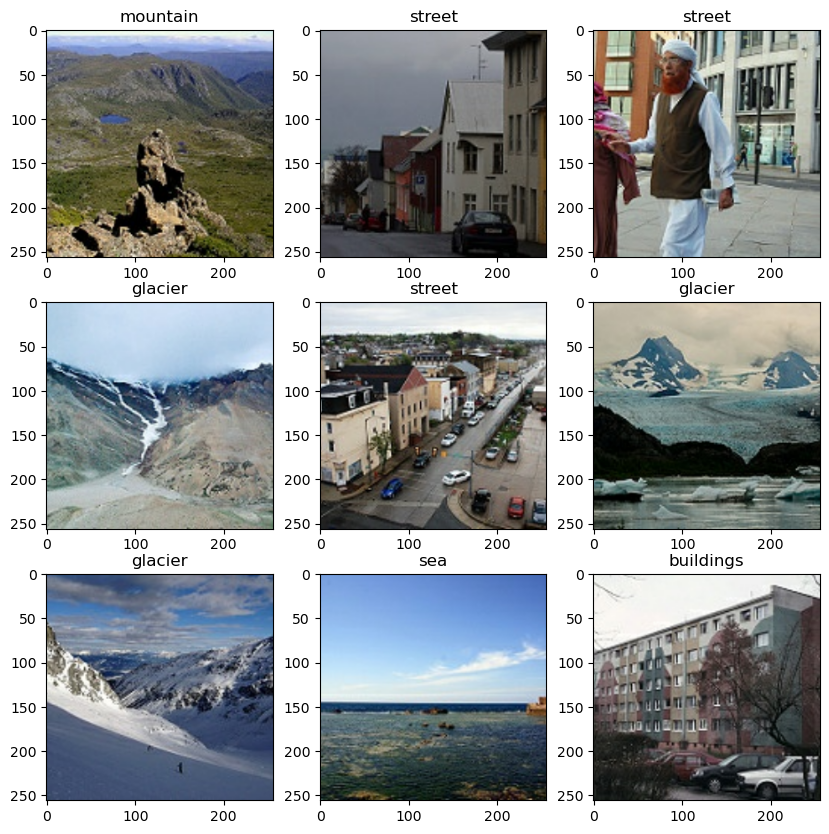

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

In [9]:
#Normalizing the data
def preprocess(image,label):
    image = tf.cast(image/255.,tf.float32)
    return image,label

In [10]:
train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

In [11]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding = 'valid',activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding = 'valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 128)               3

In [12]:
model.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=['accuracy'])

In [13]:
callback = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')

In [14]:
history = model.fit(train_ds,epochs=15,validation_data=test_ds,callbacks=[callback])

Epoch 1/15
439/439 [==============================] - 108s 223ms/step - loss: 1.9051 - accuracy: 0.2692 - val_loss: 1.5369 - val_accuracy: 0.3230
Epoch 2/15
439/439 [==============================] - 33s 75ms/step - loss: 1.5617 - accuracy: 0.3050 - val_loss: 1.4557 - val_accuracy: 0.3620
Epoch 3/15
439/439 [==============================] - 30s 67ms/step - loss: 1.3843 - accuracy: 0.3955 - val_loss: 1.5525 - val_accuracy: 0.2897
Epoch 4/15
439/439 [==============================] - 32s 72ms/step - loss: 1.2531 - accuracy: 0.4394 - val_loss: 1.1437 - val_accuracy: 0.4877
Epoch 5/15
439/439 [==============================] - 29s 66ms/step - loss: 1.1899 - accuracy: 0.4647 - val_loss: 1.1135 - val_accuracy: 0.4837
Epoch 6/15
439/439 [==============================] - 29s 65ms/step - loss: 1.1162 - accuracy: 0.4931 - val_loss: 1.0967 - val_accuracy: 0.5107
Epoch 7/15
439/439 [==============================] - 34s 77ms/step - loss: 1.0794 - accuracy: 0.5008 - val_loss: 1.0594 - val_accurac

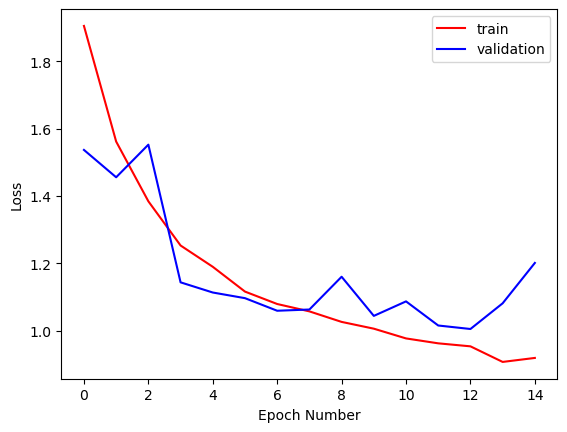

In [15]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'],color='red', label='train')
plt.plot(history.history['val_loss'],color='blue', label='validation')
plt.legend()
plt.show()

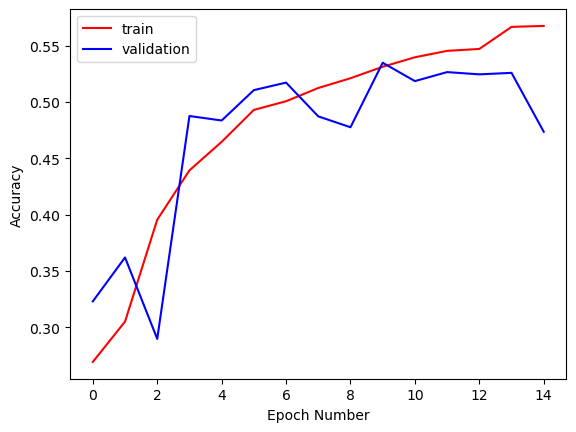

In [16]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'],color='red', label='train')
plt.plot(history.history['val_accuracy'],color='blue', label='validation')
plt.legend()
plt.show()

**Prediction on all seg_train,seg_test and seg_pred image data**

In [17]:
#Preprocessing the input image
import cv2
def processing(path):
    test_image = cv2.imread(path)
    plt.imshow(test_image)
    test_image = cv2.resize(test_image,(256,256))
    test_input = test_image.reshape((1,256,256,3))
    return test_input

In [18]:
#Prediction
def prediction(model,test_data):
    prediction = model.predict(test_data)
    index = np.argmax(prediction)
    print('Predicted image--->',class_names[index])

1/1 [==============================] - 0s 161ms/step
Predicted image---> buildings


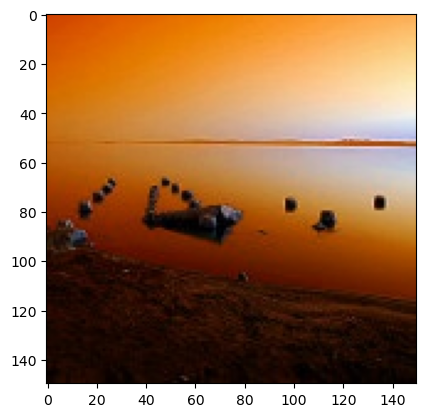

In [19]:
#Prediction on seg_train data
train_input = processing('/kaggle/input/intel-image-classification/seg_train/seg_train/sea/10053.jpg')
prediction(model,train_input)

1/1 [==============================] - 0s 18ms/step
Predicted image---> forest


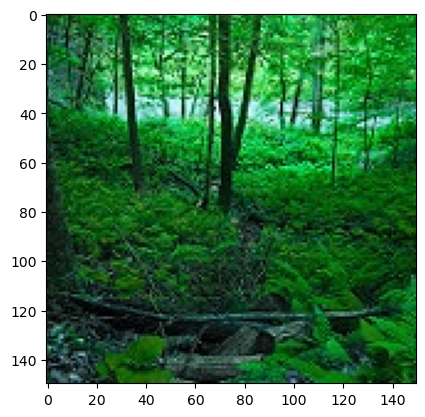

In [20]:
#Prediction on seg_test data
test_input = processing('/kaggle/input/intel-image-classification/seg_test/seg_test/forest/20098.jpg')
prediction(model,test_input)

1/1 [==============================] - 0s 19ms/step
Predicted image---> street


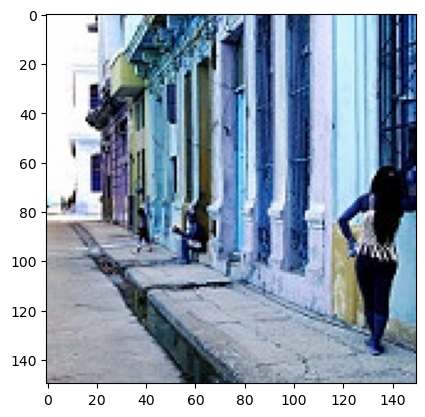

In [21]:
#Prediction on seg_pred data
unseen_input_1 = processing('/kaggle/input/intel-image-classification/seg_pred/seg_pred/10045.jpg')
prediction(model,unseen_input_1)

1/1 [==============================] - 0s 20ms/step
Predicted image---> street


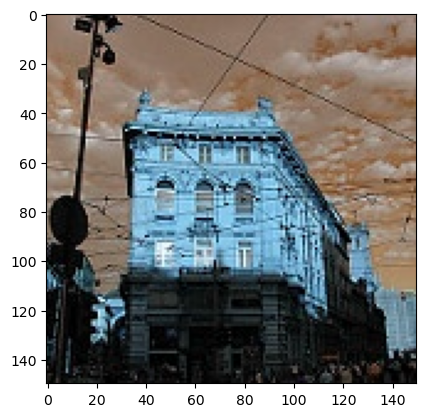

In [22]:
unseen_input_2 = processing('/kaggle/input/intel-image-classification/seg_pred/seg_pred/10048.jpg')
prediction(model,unseen_input_2)

1/1 [==============================] - 0s 28ms/step
Predicted image---> forest


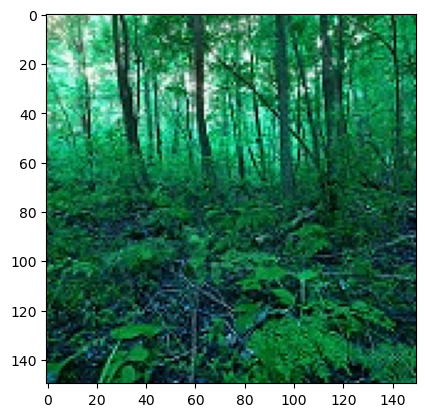

In [23]:
unseen_input_3 = processing('/kaggle/input/intel-image-classification/seg_pred/seg_pred/10060.jpg')
prediction(model,unseen_input_3)

1/1 [==============================] - 0s 19ms/step
Predicted image---> mountain


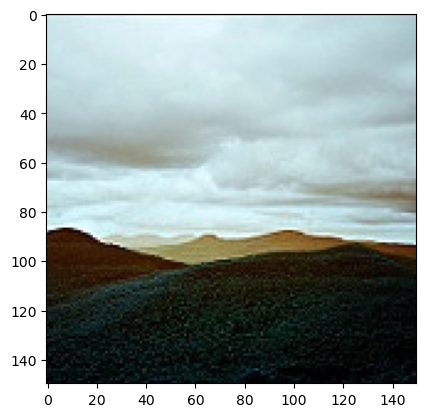

In [24]:
unseen_input_4 = processing('/kaggle/input/intel-image-classification/seg_pred/seg_pred/10100.jpg')
prediction(model,unseen_input_4)